In [604]:
import numpy as np

import math

import random

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from itertools import combinations

from scipy.stats import ttest_ind

import os

from collections import Counter

%matplotlib inline
import warnings; warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 50) # выведем больше строк

pd.set_option('display.max_columns', 50) # выведем больше колонок

print(os.listdir("../input"))


['imbd-sf', 'UNICEF_stud_math']


In [605]:

df = pd.read_csv('../input/UNICEF_stud_math/stud_math.csv')


In [606]:
def changeVal(columnsList, oldVal1, newVal1, oldVal2, newVal2):

    for col in columnsList:
        df[col] = df[col].apply(lambda x: newVal1 if str(x).strip() == oldVal1 and str(x).strip() != oldVal2 else newVal2 if str(x).strip() == oldVal2 and x.strip() != oldVal1 else x)

In [607]:
changeVal(['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher','internet',	'romantic'],'yes',1,'no',0)
changeVal(['famsize'],'LE3',0,'GT3',1)
changeVal(['Pstatus'],'T',1,'A',0)
changeVal(['address'],'U',1,'R',0)
changeVal(['school'],'GP',1,'MS',0)
changeVal(['sex'],'F',0,'M',1)

In [608]:
def get_boxplot4Val(column):
    try:
        fig, ax = plt.subplots(figsize = (14, 4))
        df.boxplot(column)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + column)
        plt.show()
    except:
        return

In [609]:
def get_his4Val(column, df1=df):
    try:
        fig, ax = plt.subplots(figsize = (14, 4))
        df1[column].hist()
        plt.xticks(rotation=45)
        ax.set_title('Hist for ' + column)
        plt.show()
    except:
        return

In [610]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df,#.loc[cacao.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [611]:
def get_histplot(column, y='score'):
    #fig, ax = plt.subplots(figsize = (14, 4))
    sns.jointplot(x=column, y=y,data=df, kind='reg') 
    # plt.xticks(rotation=45)
    #ax.set_title('Boxplot for ' + column)
    plt.show()

In [612]:
def get_barplot(column, hue, y='score', func=np.median):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.barplot(y=y, x=column, hue=hue, data=df, estimator=func, ax=ax)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + 'column')
    plt.show()

In [613]:
def get_stat_dif(column): 
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    pvl=[]
    for comb in combinations_all:
        pvalue = ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], df.loc[df.loc[:, column] == comb[1], 'score']).pvalue
        pvl.append(pvalue)
        if pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    #print(pvl, '---', len(combinations_all))

In [614]:
def getMainStatistics(column, returnTuple = False, df1=df):
    '''
    Возвращаем:
    perc25 - 1.5*IQR, perc25, IQR, perc75, perc75 + 1.5*IQR, median, mean, minCol, maxCol
    '''
    median = df1[column].median()
    mean = df1[column].mean()
    minCol = df1[column].min()
    maxCol = df1[column].max()
    perc25 = df1[column].quantile(0.25)
    perc75 = df1[column].quantile(0.75)
    IQR = perc75 - perc25

    if returnTuple:
        return perc25 - 1.5*IQR, perc25, IQR, perc75, perc75 + 1.5*IQR, median, mean, minCol, maxCol
    else:
        print(f'--{column}--  perc25 - 1.5*IQR={perc25 - 1.5*IQR}; perc25={perc25}; IQR={IQR}; perc75={perc75}; perc75 + 1.5*IQR ={perc75 + 1.5*IQR}; median={median}; mean={mean}; min={minCol}; max={maxCol}')
        

In [615]:
def getCorrelationFeatures(col, N_features='all', df1=df):

    r_limit = np.round(2/(np.sqrt(len(df1.index))),2)

    r = round(df1.corr(),2)

    if N_features=='all':
        N_features = len(r)
    else:
        N_features+=1

    r_ser=(r[ (( r > 0)&(r >= r_limit)) | (( r < 0)&(r <= -r_limit))][col].dropna())#.index
    r_ser=r_ser.reindex(r_ser.abs().sort_values(ascending = False).index)[:N_features]
    #r_NamesList=r_ser.index#[:N_features]

    return r_ser

In [616]:
#test
getCorrelationFeatures(col='romantic', df1=df)

romantic    1.00
score      -0.14
age         0.14
higher     -0.13
sex        -0.13
internet    0.10
failures    0.10
Name: romantic, dtype: float64

In [617]:
def calcNumbFeature(groupbyList, filterQuery, targetFeature, func='mean', silent=False, df1=df):
    res=np.NaN
    grouped_df=df1.groupby(groupbyList)['age'].count().to_frame(name="count").reset_index().query(filterQuery)
    rowsCount = 0
    if (len(grouped_df.index) > 0):
        rowsCount = len(grouped_df.index)
        if func == 'mean':
            res = pd.Series(sum(grouped_df[targetFeature])/sum(grouped_df['count']))
        elif func == 'median':
            res = pd.Series(grouped_df[targetFeature].median())         
        elif func == 'mostfreq':
            res =  pd.Series(grouped_df.dropna(subset=[targetFeature])[targetFeature].value_counts().idxmax())
        else:
            res=pd.Series(np.NaN)
    else:
        res = pd.Series(res)#df.dropna(subset=[targetFeature])[targetFeature].value_counts().idxmax())
        print(res)
    if silent == False:
        print(f'Выбрано {rowsCount} строк;  Значение для {targetFeature}={res.values.round()}')
        display(grouped_df)
    return res.values.round()

In [618]:
#test
calcNumbFeature(groupbyList=['romantic',  'score', 'age', 'higher', 'sex', 'internet',
       'failures'], filterQuery='(   (score >= 55) & (age >= 17 ) & (higher == 1) & (sex == 1) & (internet == 0)) ', targetFeature='romantic',  func='mostfreq', silent=False)[0]

Выбрано 3 строк;  Значение для romantic=[0.]


,romantic,score,age,higher,sex,internet,failures,count
92,0.0,60.0,18,1.0,1,0.0,0.0,1
98,0.0,65.0,17,1.0,1,0.0,0.0,1
130,0.0,90.0,20,1.0,1,0.0,0.0,1


0.0

In [619]:
def calc_Feature_basedOnSimilarity():#(targetFeature,filterQuery, func='mostfreq', N_features=5, df1=df):
    corrS = getCorrelationFeatures(col=targetFeature, N_features=N_features, df1=df1)
    print(corrS, N_features)
    return calcNumbFeature( corrS.index.tolist(), filterQuery, targetFeature, func, silent=False, df1=df)#[0]


In [620]:
#test
targetFeature = 'romantic'
filterQuery ='(   (score >= 55) & (age >= 17 ) & (higher == 1) & (sex == 1) & (internet == 0)   ) ' #
N_features = 15
df1 =df
func = 'mostfreq'

calc_Feature_basedOnSimilarity()


romantic    1.00
score      -0.14
age         0.14
higher     -0.13
sex        -0.13
internet    0.10
failures    0.10
Name: romantic, dtype: float64 15
Выбрано 3 строк;  Значение для romantic=[0.]


,romantic,score,age,higher,sex,internet,failures,count
92,0.0,60.0,18,1.0,1,0.0,0.0,1
98,0.0,65.0,17,1.0,1,0.0,0.0,1
130,0.0,90.0,20,1.0,1,0.0,0.0,1


array([0.])

In [621]:
def calc_Feature_basedOnSimilarityROW(row):
    if not pd.isna(row[targetFeature]): return row[targetFeature]
    corrS = getCorrelationFeatures(col=targetFeature, N_features=N_features, df1=df1)
    return calcNumbFeature(corrS.index.tolist(), filterQuery, targetFeature, func, silent=True, df1=df)[0]

romantic NaN = 31


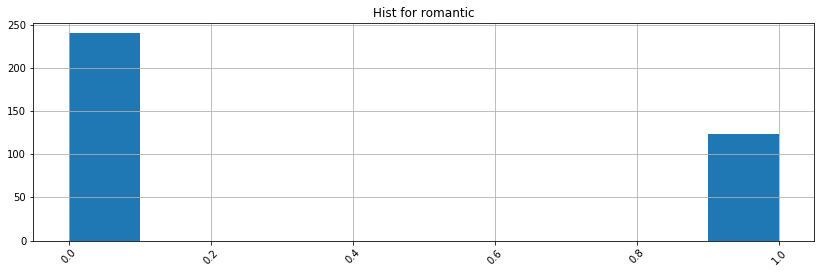

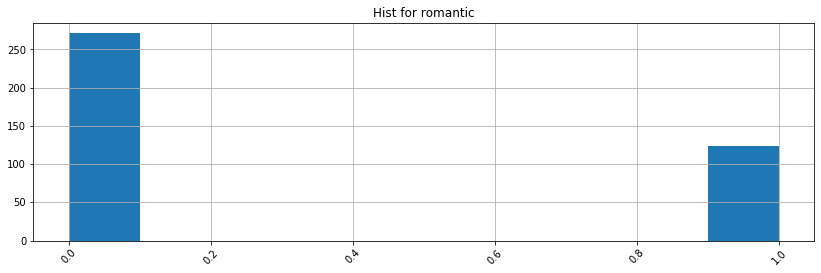

romantic NaN = 0


In [622]:
print('romantic NaN =', len(df[pd.isna(df.romantic)].index))
get_his4Val('romantic')

targetFeature = 'romantic'
filterQuery ='(  (score >= 55) & (age >= 17 ) & (higher == 1) & (sex == 0) & (internet == 0)) '
N_features = 6
df1 =df.copy()
func = 'mostfreq'
df['romantic'] = df.apply(calc_Feature_basedOnSimilarityROW, axis=1)

get_his4Val('romantic')
print('romantic NaN =', len(df[pd.isna(df.romantic)].index))

In [623]:
#get_histplot('absences', 'school') #толко есл число

In [624]:
#Ищем потенциальные вылеты и странности, оцениваем распределение и пропорции - done!
# for col in df.columns:
#     get_his4Val(col)

In [625]:
#Убираем вылет по Образованию отца, принимаем, что ошиблись при вводе. ввели 40 д.б. 4.0 Уровень образования 0-оставляем т.к. он есть в классификации и встречается в жизни. 
df.loc[df.Fedu == 40,'Fedu'] = 4


--age--  perc25 - 1.5*IQR=13.0; perc25=16.0; IQR=2.0; perc75=18.0; perc75 + 1.5*IQR =21.0; median=17.0; mean=16.696202531645568; min=15; max=22


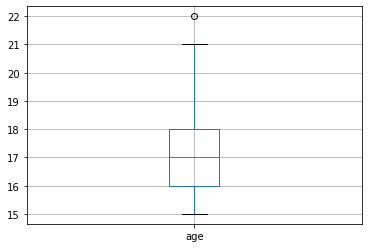

In [626]:
df.boxplot('age')
getMainStatistics('age')

df.age >18 #Старше 18 лет 29чел. 7% от общего числа и все похожи на "живых людей"

In [627]:
#famrel Есть 1 выброс -1 - предполагаем, что ошибка ввода или так плохо в семье :) - назначаем наиболее логичное значение 
df.loc[df.famrel < 1,'famrel'] = 1


--absences--  perc25 - 1.5*IQR=-12.0; perc25=0.0; IQR=8.0; perc75=8.0; perc75 + 1.5*IQR =20.0; median=4.0; mean=7.2793733681462145; min=0.0; max=385.0


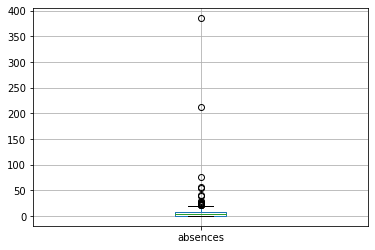

In [628]:
df.boxplot('absences')
getMainStatistics('absences')
#df[df.absences > 20]

Вылетов (всё что больше perc75 + 1.5*IQR) всего 4.3% Если исходить из того, что чебный год в США длится, как правило, 170-186 дней и absences - это количество пропущенных ЛЮБЫХ учебных занятий, то даже 385 занятий - это 2-3 пропущенных занятия в день. Логичных причин может быть много, например освобождение от занятий в связи с домашним обучением и/или результатами или просто прогулами, таких всего 0.5%. 

Для упрощения понимания общей картины, всё равно заменим  "вылеты" более 75 на медианное значение. 

absences подверглось обработке  0.51 %
--absences--  perc25 - 1.5*IQR=-12.0; perc25=0.0; IQR=8.0; perc75=8.0; perc75 + 1.5*IQR =20.0; median=4.0; mean=5.741514360313316; min=0.0; max=75.0


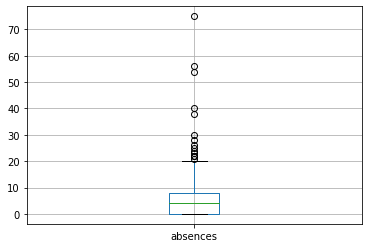

In [629]:
print('absences подверглось обработке ',round(len(df[df.absences > 75])/len(df.index) * 100,2),'%') #20
 
df.loc[df.absences > 75,'absences'] = df.absences.median() #20
df.boxplot('absences')
getMainStatistics('absences')

#  Устраняем NaN в famsize
Промежуточные выводы:
1. Живущие <i>вместе</i> родители с образованием одного из родителей (или обоих) хуже чем "2" (менее 5-9 классов), скорее всего имеют одного ребенка -- LE3 0 Вероятно, бюджет не позволяет, НО до люмпен-пролетариата ещё не дошло т.к ребенок ходит в школу. </br>  
2. Т.к. с 1960г по 2019г средняя Американская семья больше 3-х человек, например в 2019г. == 3.14
https://www.statista.com/statistics/183657/average-size-of-a-family-in-the-us/
Т.о., для группы живущих <i>вместе</i> родителей (т.к. уже 3 человека минимум есть) принимаем пропущенные значения famsize = 'GT3' 1  
<!--3. Для учеников имеющих родителей живущих порознь, важен параметр absences, при значении 9 и выше принимаем пропущенные famsize значения = 'LE3'. По всей видимости, ребенком некому заниматься-->  




1. Живущие вместе родители с образованием одного из родителей хуже чем "2" (менее 5-9 классов), скорее всего имеют одного ребенка LE

In [630]:
df.loc[((pd.isna(df.famsize)) & (df.Pstatus == 1)) & ((df.Medu <=2) | (df.Fedu <= 2)),'famsize'] = 0#'LE3'

2. Т.к. с 1960г по 2019г средняя Американская семья больше 3-х человек, например в 2019г. == 3.14 https://www.statista.com/statistics/183657/average-size-of-a-family-in-the-us/ То, для группы живущих вместе родителей (т.к. уже 3 человека минимум есть) принимаем пропущенные значения famsize = 'GT3'

In [631]:
df.loc[(pd.isna(df.famsize)) & ( df.Pstatus == 1),'famsize'] =1#'GT3'

Всего 4 записи №№[9, 252, 268, 313] с NAN famsize & Pstatus, непонятно что с ними делать, будет рандом.
Также заполняем оставшиеся 3 famsize значениеми из следующей строки

In [632]:
f=df[(pd.isna(df.famsize)) & (pd.isna(df.Pstatus))].index

df.iloc[f, df.columns.get_loc('famsize')] = random.choice([1, 0])
df.iloc[f, df.columns.get_loc('Pstatus')] = random.choice([1, 0])
df['famsize'].fillna( method ='bfill', inplace = True) 


#  Устранаям NaN в address

In [633]:

gg=df.query('(address == 1) & (sex==0)').groupby(['score', 'failures', 'Medu', 'higher', 'age', 'romantic', 'goout', 'Fedu'])['age'].count().to_frame(name="count").reset_index()

score = gg.query('(failures==2) & (Medu >3) & (higher ==1)')['score'].sum()/gg.query('(failures==2) & (Medu >3) & (higher ==1)')['count'].sum()
round(score)

30.0

In [634]:
#Минимальный статистически-значемый коэфф. исходя из размера выборки
r_limit = np.round(2/(np.sqrt(len(df.index))),2)
print(r_limit)
r = round(df.corr(),2) #NaN из-за фильтра
col='romantic'
display(abs(r[abs(r) >= r_limit ][col]).sort_values(ascending=False).dropna())#.index
abs(r[abs(r) >= r_limit ][col]).sort_values(ascending=False).dropna().index.tolist()

0.1


romantic    1.00
absences    0.15
age         0.15
score       0.14
sex         0.14
higher      0.13
failures    0.10
Name: romantic, dtype: float64

['romantic', 'absences', 'age', 'score', 'sex', 'higher', 'failures']

In [635]:
#здесь нужно разобраться руками т.к. эти строки влияют на автоматическую обработку адреса 
display(df.loc[ (df.index!=-1) & (pd.isna(df.address)) & ( (pd.isna(df.internet)) | (pd.isna(df.traveltime)) | (pd.isna(df.failures)) | (pd.isna(df.Medu)) | (pd.isna(df.score)) )])
df.loc[ (df.index==92) , ['address','Medu']]=[0, 1] # по всем признакам это address=R, Medu=1 для этой группы образования

df.loc[ (df.index==52) , ['address','Fjob', 'famsup', 'internet']]=[0, 'other', 0, 0] # по всем признакам это address=R, Fjob=other исходя из Образование, работа матери + образование отца для выяснениия возможной работы отца, famsup =0 т.к. разведенные родители, ребенок живет с отцом, отец с невысоким уровнем образования

df.loc[ (df.index==241) , ['address','traveltime', 'goout']]=[1, 1, 3] # по всем признакам это address=U traveltime =1 как самое распространенное для U; df[(df.freetime==3) & (df.age==17)].groupby([ 'freetime', 'age', 'score', 'failures', 'internet','goout'])['age'].count() - 3 для goout

df.loc[ (df.index==270) , ['address','score', 'goout', 'score']]=[1, 1, 3, 30]

df.loc[ (df.index==348) , ['address','famrel']]=[1, 4] #calcNumbFeature(groupbyList=['famrel', 'freetime', 'age', 'sex'], filterQuery=' (freetime ==4) & (age == 17) & (sex == 0) ', targetFeature='famrel',  func='mostfreq', silent=False)[0]

df.loc[ (df.index==350) , ['address','nursery', 'score']]=[0, 0, 50]  

df.loc[ (df.index==372) , ['address','traveltime', 'romantic']]=[1, 1, 0] 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
52,1,1,15,NaN,0.0,0.0,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,0.0,NaN,0.0,0.0,1.0,-3.0,1.0,NaN,0.0,5.0,5.0,5.0,5.0,6.0,50.0
92,1,0,16,NaN,0.0,1.0,NaN,1.0,other,other,home,father,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,-6.0,1.0,0.0,0.0,3.0,3.0,NaN,2.0,4.0,30.0
241,1,1,17,NaN,0.0,0.0,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,1.0,0.0,3.0,3.0,NaN,4.0,2.0,60.0
270,1,0,19,NaN,1.0,1.0,3.0,3.0,other,services,home,other,1.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,0.0,4.0,3.0,5.0,5.0,NaN,NaN
348,1,0,17,NaN,1.0,1.0,4.0,3.0,health,other,reputation,mother,NaN,3.0,0.0,0.0,1.0,1.0,1.0,1.0,-9.0,1.0,1.0,1.0,NaN,4.0,3.0,4.0,0.0,75.0
350,0,1,19,NaN,1.0,1.0,1.0,1.0,other,services,home,other,3.0,2.0,3.0,0.0,0.0,0.0,0.0,NaN,-6.0,1.0,1.0,0.0,5.0,4.0,4.0,2.0,8.0,NaN
372,0,0,17,NaN,1.0,1.0,2.0,2.0,other,at_home,home,mother,NaN,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-9.0,1.0,0.0,0.0,3.0,4.0,3.0,3.0,8.0,55.0


In [636]:
#get_barplot('failures','address','score',func=np.median )

In [637]:
 getMainStatistics('score', False, df[(df.address==1) & (df.failures==1)])

--score--  perc25 - 1.5*IQR=8.125; perc25=36.25; IQR=18.75; perc75=55.0; perc75 + 1.5*IQR =83.125; median=40.0; mean=39.166666666666664; min=0.0; max=90.0


In [638]:
#Минимальный статистически-значемый коэфф. исходя из размера выборки
r_limit = np.round(2/(np.sqrt(len(df.index))),2)
print(r_limit)
r = round(df.corr(),2) #NaN из-за фильтра
col='score'
display(abs(r[abs(r) >= r_limit ][col]).sort_values(ascending=False).dropna())#.index
abs(r[abs(r) >= r_limit ][col]).sort_values(ascending=False).dropna().index

0.1


score                  1.00
failures               0.34
Medu                   0.22
higher                 0.18
age                    0.16
goout                  0.13
romantic               0.13
Fedu                   0.13
studytime, granular    0.12
studytime              0.12
address                0.12
paid                   0.10
sex                    0.10
Name: score, dtype: float64

Index(['score', 'failures', 'Medu', 'higher', 'age', 'goout', 'romantic',
       'Fedu', 'studytime, granular', 'studytime', 'address', 'paid', 'sex'],
      dtype='object')

In [639]:
#sns.pairplot(df, kind = 'reg')

In [640]:
#df.loc[(pd.isna(df.famsize)) & ( df.Pstatus == 'T')  ,'famsize'] ='GT3'
#df.loc[(pd.isna(df.famsize)) & ( df.Pstatus == 'T')]


In [641]:
# df1=pd.get_dummies(df[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
#        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
#        'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
#        'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
#        'freetime', 'goout', 'health', 'absences', 'score']])
# df1

In [642]:
# # df.Fjob.fillna(method='backfill', axis=0, inplace=True)
# df.fillna(method='backfill', axis=0, inplace=True)
# for col in [	'Fjob',	'reason',	'guardian',	'traveltime',	'studytime',	'failures',	'schoolsup',	'famsup',	'paid',	'activities',	'nursery',	'higher',	'internet',	'romantic',	'famrel', 'freetime',	'goout',	'health','Mjob',	'absences']:
#     get_stat_dif(col)

In [643]:
# changeVal(['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher','internet',	'romantic'],'yes',1,'no',0)
# changeVal(['famsize'],'LE3',0,'GT3',1)
# changeVal(['Pstatus'],'T',1,'A',0)
# changeVal(['address'],'U',1,'R',0)

In [644]:
# for col in df.columns: # ['school',	'sex',	'age',	'address',	'famsize',	'Pstatus',	'Medu',	'Fedu',	'Mjob',	'Fjob',	'reason',	'guardian',	'traveltime',	'studytime',	'failures',	'schoolsup',	'famsup',	'paid',	'activities',	'nursery',	'higher',	'internet',	'romantic',	'famrel', 'freetime',	'goout',	'health',	'absences']:
#      get_boxplot(col)	
    	

In [645]:
#df.loc[pd.isna(df.address)]

In [646]:
df.corr(method='spearman').score.round(2)*100

school                   6.0
sex                     10.0
age                    -17.0
address                 14.0
famsize                 -2.0
Pstatus                 -3.0
Medu                    22.0
Fedu                    15.0
traveltime              -8.0
studytime               12.0
failures               -36.0
schoolsup              -16.0
famsup                  -2.0
paid                     6.0
activities               2.0
nursery                  3.0
studytime, granular    -12.0
higher                  17.0
internet                 7.0
romantic               -10.0
famrel                   6.0
freetime                 1.0
goout                  -16.0
health                  -6.0
absences                 2.0
score                  100.0
Name: score, dtype: float64

-0.088650	-0.007540  
Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [647]:
df.corrwith(df.score).round(3)*100

school                   4.4
sex                     10.1
age                    -15.9
address                 12.4
famsize                 -3.3
Pstatus                 -4.6
Medu                    21.5
Fedu                    13.0
traveltime              -7.0
studytime               11.6
failures               -34.2
schoolsup               -8.7
famsup                  -0.9
paid                     9.7
activities               0.9
nursery                  5.2
studytime, granular    -11.6
higher                  18.5
internet                 6.3
romantic               -13.4
famrel                   5.5
freetime                 1.9
goout                  -12.9
health                  -7.3
absences                 3.1
score                  100.0
dtype: float64

In [648]:
for col in [	'Fjob',	'reason',	'guardian',	'traveltime',	'studytime',	'failures',	'schoolsup',	'famsup',	'paid',	'activities',	'nursery',	'higher',	'internet',	'romantic',	'famrel', 'freetime',	'goout',	'health','Mjob',	'absences']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Mjob


In [649]:
df.Mjob.value_counts()


other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64